#  Customer Value Regression

In [1]:
import numpy as np
import pandas as pd 
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
import problem

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Introduction

In this notebook, the goal is to predict the amount that a customer is willing to pay for his insurance. 

A preliminary study is based on the exploration of these two datasets; the first one is related to the customer (his income, his gender, his age, etc.) the second one describes the various policies adopted by the insurance company.

The idea here is to determine, based on customers profiles, the most appropriate policy for both the customer and the company.

The problem studied here is a regression problem. the metric we will use to mesure the performance of the model is the Normalized RMSE given by the following formula:
$$ NRMSE = \frac{\sqrt{\frac{1}{n}\sum_{i=1}^n(y_{true_i}-\hat{y}_{pred_i})^2}}{\sigma_{y_{true}}} $$ 
with : $$\sigma^2_{y_{true}}=\frac{1}{n-1}\sum_{i=1}^n\sum_{j=1}^n(y_{true_i}-y_{true_j})^2 $$

**Loading data :**

In [3]:
X_train=pd.read_csv('data/train.csv')
X_test=pd.read_csv('data/test.csv')

**Cleaning data and EDA :**

*1- Type of data :* 

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8582 entries, 0 to 8581
Data columns (total 22 columns):
policy_id                       8582 non-null object
customer_id                     8582 non-null object
agent_id                        8582 non-null object
policy_status                   8582 non-null object
last_payment_dt                 8582 non-null object
payment_method                  5561 non-null object
policy_issue_dt                 8582 non-null object
contact_channel                 8582 non-null object
product_code                    8582 non-null object
policy_status_cd                8582 non-null object
sum_assured                     8582 non-null float64
nb_riders                       8582 non-null float64
time_stamp_x                    8582 non-null object
customer_origin                 8582 non-null object
customer_gender                 8582 non-null object
customer_marital_cd             8582 non-null int64
customer_age                    8582 non-nul

In [5]:
g = X_train.columns.to_series().groupby(X_train.dtypes).groups

## int column:
int_col=list(g.values())[0].tolist()

## float column:
Float_col=list(g.values())[1].tolist()

## object column:
obj_col=list(g.values())[2].tolist()

In [6]:
# Finding categorical variables among int columns : 
dict_unique_int={}
dict_unique_int_name=[]

for i in int_col:
    if(pd.unique(X_train[i]).shape[0]<10):
        dict_unique_int[i]=pd.unique(X_train[i]).shape[0]
        dict_unique_int_name.append(i)


In [7]:
dict_unique_int

{'customer_marital_cd': 4}

In [8]:
# Finding categorical variables among float columns : 

dict_unique_float={}
dict_unique_float_name=[]

for i in Float_col:
    if(pd.unique(X_train[i]).shape[0]<6):
        dict_unique_float[i]=pd.unique(X_train[i]).shape[0]
        dict_unique_float_name.append(i)

In [9]:
dict_unique_float

{}

In [10]:
# Finding categorical variables among object columns : 

dict_unique_object={}
dict_unique_object_name=[]
col_potentially_to_drop=[]

for i in obj_col:
    if(pd.unique(X_train[i]).shape[0]<6):
        dict_unique_object[i]=pd.unique(X_train[i]).shape[0]
        dict_unique_object_name.append(i)
    else : 
        col_potentially_to_drop.append(i)

In [11]:
dict_unique_object

{'policy_status': 1,
 'payment_method': 2,
 'contact_channel': 4,
 'policy_status_cd': 2,
 'time_stamp_x': 1,
 'customer_origin': 2,
 'customer_gender': 3,
 'time_stamp_y': 1}

*2- Drop columns :*

In [12]:
X_train = X_train.drop(columns=['policy_id', 'customer_id', 'agent_id','policy_status','time_stamp_x','time_stamp_y', 'product_code'])

*3- Drop duplicated values :*

In [13]:
X_train = X_train.drop_duplicates()

*4- Transform to time stamp the date columns:*

In [14]:
X_train.last_payment_dt = pd.to_datetime(X_train.last_payment_dt)
X_train.policy_issue_dt = pd.to_datetime(X_train.policy_issue_dt)


*5- missing values :*

In [15]:
## identifying columns with missing values:
col_X_train = X_train.columns
columns_with_nan_values = []

for col_merge in col_X_train:
    non_nan_values = X_train[col_merge].isnull().sum()
    if non_nan_values != 0:
        columns_with_nan_values.append(col_merge)

In [16]:
columns_with_nan_values

['payment_method', 'customer_income']

*6- Observing distribution for the columns with nan values :*

For the payment_method column we can see that the only values taken in this columns are nan and auto. We can suppose that except the nan values we have one category value for all column . So we can just drop it.



In [17]:
X_train.drop(columns='payment_method',inplace=True)

Now, we will try to get more information about our dataset and we will try to go further with our feature engeeniring. 


In [18]:
X_train.head()

,last_payment_dt,policy_issue_dt,contact_channel,policy_status_cd,sum_assured,nb_riders,customer_origin,customer_gender,customer_marital_cd,customer_age,customer_social_group,customer_income,customer_additional_products,Total_Price
0,2016-06-30,2016-06-30,agency,A,1360000.0,2.0,new,M,1,35.0,2.0,55000.0,2,5300.0
1,2016-02-29,2016-02-29,broker,A,1378000.0,2.0,new,F,2,30.0,7.0,65000.0,1,3300.0
2,2016-08-31,2016-08-31,broker,A,1216000.0,2.0,new,M,1,30.0,4.0,70000.0,1,3300.0
3,2016-07-31,2016-09-30,agency,A,1108000.0,2.0,new,F,2,50.0,6.0,175000.0,1,3700.0
4,2016-09-30,2015-09-30,agency,A,1108000.0,2.0,new,F,2,55.0,3.0,NaN,1,2600.0


In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8549 entries, 0 to 8581
Data columns (total 14 columns):
last_payment_dt                 8549 non-null datetime64[ns]
policy_issue_dt                 8549 non-null datetime64[ns]
contact_channel                 8549 non-null object
policy_status_cd                8549 non-null object
sum_assured                     8549 non-null float64
nb_riders                       8549 non-null float64
customer_origin                 8549 non-null object
customer_gender                 8549 non-null object
customer_marital_cd             8549 non-null int64
customer_age                    8549 non-null float64
customer_social_group           8549 non-null float64
customer_income                 7965 non-null float64
customer_additional_products    8549 non-null int64
Total_Price                     8549 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(2), object(4)
memory usage: 1001.8+ KB


In [20]:
cols = X_train.columns

for col in cols:
    print('\n The col :', col, '\n \n \n', X_train[col].unique())


 The col : last_payment_dt 
 
 
 ['2016-06-30T00:00:00.000000000' '2016-02-29T00:00:00.000000000'
 '2016-08-31T00:00:00.000000000' '2016-07-31T00:00:00.000000000'
 '2016-09-30T00:00:00.000000000' '2016-10-31T00:00:00.000000000'
 '2016-11-30T00:00:00.000000000' '2016-12-31T00:00:00.000000000'
 '2016-01-31T00:00:00.000000000' '2016-02-28T00:00:00.000000000'
 '2016-03-31T00:00:00.000000000' '2016-04-30T00:00:00.000000000'
 '2016-05-31T00:00:00.000000000']

 The col : policy_issue_dt 
 
 
 ['2016-06-30T00:00:00.000000000' '2016-02-29T00:00:00.000000000'
 '2016-08-31T00:00:00.000000000' '2016-09-30T00:00:00.000000000'
 '2015-09-30T00:00:00.000000000' '2015-10-31T00:00:00.000000000'
 '2015-11-30T00:00:00.000000000' '2014-08-31T00:00:00.000000000'
 '2015-08-31T00:00:00.000000000' '2011-06-30T00:00:00.000000000'
 '2015-04-30T00:00:00.000000000' '2015-12-31T00:00:00.000000000'
 '2014-02-28T00:00:00.000000000' '2016-03-31T00:00:00.000000000'
 '2016-04-30T00:00:00.000000000' '2016-10-31T00:00:00

Policy_issue_dt and last_payment_dt can be dropped since they have no influence on what we are looking for. <br>

In [21]:
X_train.drop(columns=['last_payment_dt', 'policy_issue_dt'], inplace=True)
get_dummies_cols = ['nb_riders', 'customer_marital_cd', 'contact_channel', 'policy_status_cd', 'customer_gender', 'customer_origin', 'customer_age' ]
X_train = pd.get_dummies(X_train, columns=get_dummies_cols, drop_first=True)

A function to help us check the percentage of nan values. 

In [22]:
# Show the percentage of missing values for each column (We create a function because we will use it repeatedly)
def display_na(df): 
    """
    The function displays the percentage of missing values for each column of the dataframe.
    
    :param df: pandas dataframe whose missing values to be displayed
    """
    
    display(HTML("<h4>Percentage of missing variables for each feature:"))
    print(df.isnull().sum(axis=0) * 100 / len(df))
    

In [23]:
display_na(X_train)

sum_assured                     0.000000
customer_social_group           0.000000
customer_income                 6.831208
customer_additional_products    0.000000
Total_Price                     0.000000
nb_riders_1.0                   0.000000
nb_riders_2.0                   0.000000
nb_riders_3.0                   0.000000
nb_riders_4.0                   0.000000
nb_riders_5.0                   0.000000
customer_marital_cd_1           0.000000
customer_marital_cd_2           0.000000
customer_marital_cd_3           0.000000
contact_channel_broker          0.000000
contact_channel_direct          0.000000
contact_channel_partnership     0.000000
policy_status_cd_B              0.000000
customer_gender_F               0.000000
customer_gender_M               0.000000
customer_origin_new             0.000000
customer_age_5.0                0.000000
customer_age_15.0               0.000000
customer_age_20.0               0.000000
customer_age_25.0               0.000000
customer_age_30.

We clearly see that we have nan values in the customer income column. 

In [24]:
df_train_income = X_train.copy()
df_train_income.dropna(inplace=True)
y = df_train_income.customer_income
df_train_income.drop(columns=['customer_income'], inplace=True)
df_test_income = X_train[X_train['customer_income'].isnull()]
df_test_income.drop(columns=['customer_income'], inplace=True)

In [25]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()

model.fit(df_train_income, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [26]:
y_predicted = model.predict(df_test_income)

df_test_income['customer_income']= y_predicted

X_train.at[df_test_income.index, 'customer_income'] = df_test_income['customer_income']

In [27]:
visualisation_data=X_train.copy()

In [28]:
y_train = X_train['Total_Price']
X_train.drop(columns=['Total_Price'],inplace=True)

In [29]:
#plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

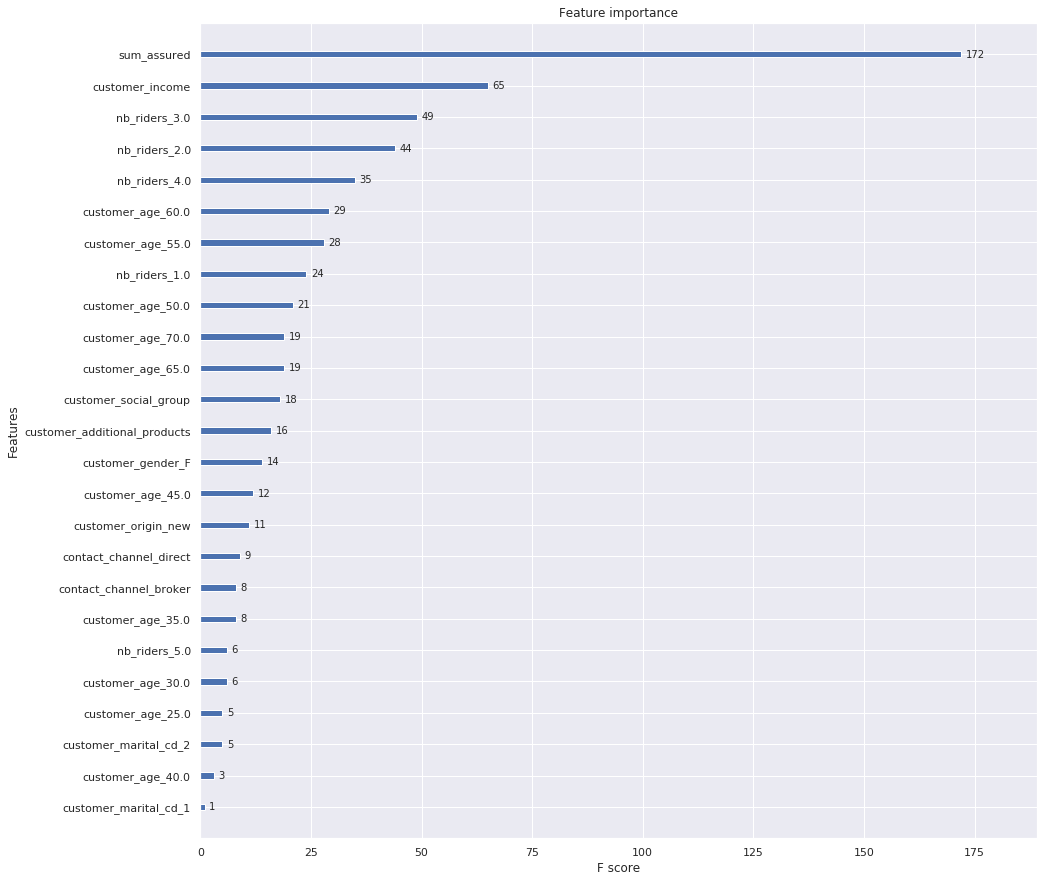

In [30]:
# plot feature importance
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
plot_importance(model ,ax=ax)

*8- Correlation :*

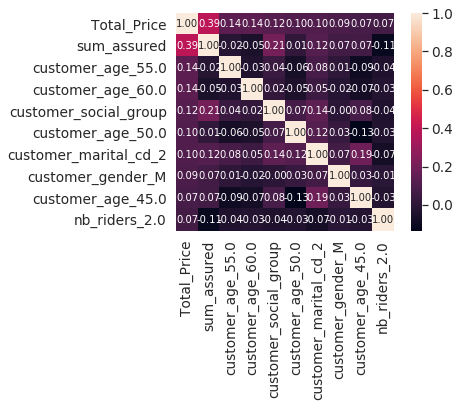

In [31]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = visualisation_data.corr()
cols = corrmat.nlargest(k, 'Total_Price')['Total_Price'].index
cm = np.corrcoef(visualisation_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

*9- pairplot correlated feature:*

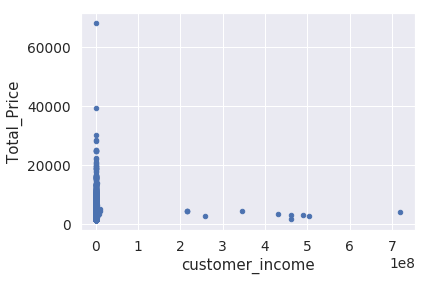

In [32]:
#scatter plot grlivarea/saleprice
var = 'customer_income'
data = pd.concat([visualisation_data['Total_Price'], visualisation_data[var]], axis=1)
data.plot.scatter(x=var, y='Total_Price');

In [33]:
visualisation_data.shape

(8549, 33)

In [34]:
visualisation_data[visualisation_data.customer_income<1e6].shape

(8478, 33)

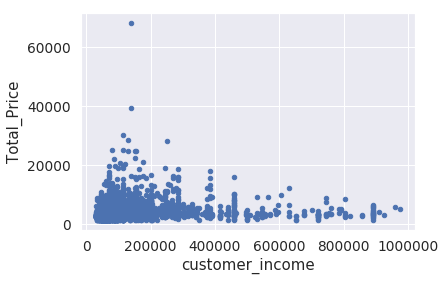

In [35]:
#scatter plot grlivarea/saleprice
visualisation_data=visualisation_data[visualisation_data.customer_income<1e6]
var = 'customer_income'
data = pd.concat([visualisation_data['Total_Price'], visualisation_data[var]], axis=1)
data.plot.scatter(x=var, y='Total_Price');

In [36]:
visualisation_data['customer_income_1']=pd.qcut(visualisation_data['customer_income'], 10)

* We have chosen to partition the income variable in order to approximate the distribution of income over the customers.
Most customers are below 400 000

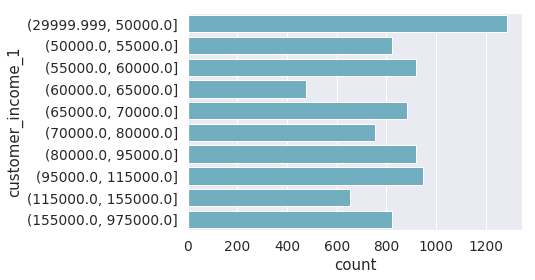

In [37]:
import seaborn as sns
sns.countplot(y="customer_income_1", data=visualisation_data, color="c");

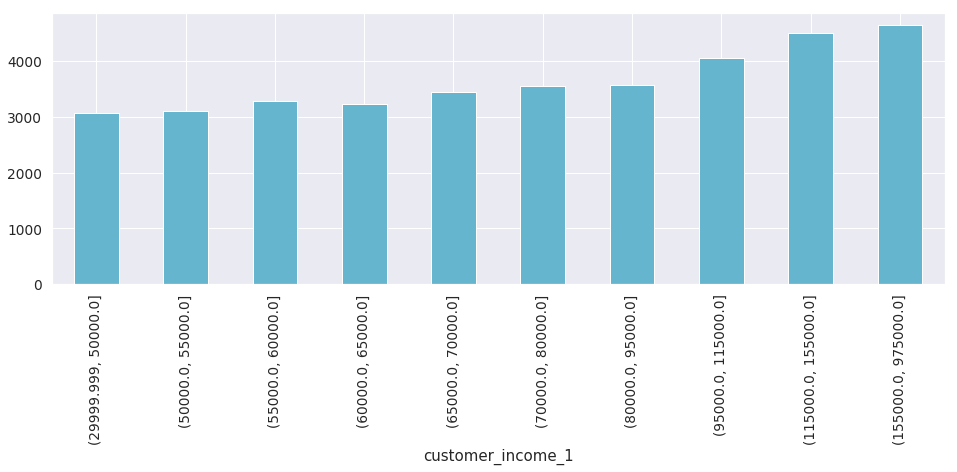

In [38]:
vis_data=visualisation_data.copy()
a=vis_data.groupby('customer_income_1').mean()['Total_Price']

a.plot(kind='bar', figsize=(16,5),color='c')
plt.show()

* This graph shows that the price a customer invests in insurance tends to increase with his budget.

**Testing with feature_extractor and regressor files:**

In [39]:
cd submissions/starting_kit/

/home/mejri/Desktop/final submission/Policy_prediction/submissions/starting_kit


In [40]:
from feature_extractor import *
from sklearn.model_selection import train_test_split
from regressor import *

In [41]:
X_train=pd.read_csv('../../data/train.csv')
X_test=pd.read_csv('../../data/test.csv')

In [42]:
y_train=X_train['Total_Price']
y_test=X_test['Total_Price']

X_train.drop(columns=['Total_Price'],inplace=True)
X_test.drop(columns=['Total_Price'],inplace=True)

In [43]:
fe= FeatureExtractor()
fe.fit(X_train,y_train)
# training set transform:
X_train=fe.transform(X_train)
# test set transform:
X_test=fe.transform(X_test)

In [44]:
model=Regressor()
model.fit(X_train,y_train)
model.predict(X_test)

array([2805.9768, 4378.79  , 3533.9497, ..., 3349.9917, 3464.3113,
       3519.5952], dtype=float32)

**Testing with ramp:**

In [45]:
cd ../..

/home/mejri/Desktop/final submission/Policy_prediction


In [46]:
!ramp_test_submission --quick-test

Testing AXA_Policy_Prediction
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
	score  normalized_rmse
	train            0.716
	valid            0.844
	test             0.809
CV fold 1
	score  normalized_rmse
	train            0.646
	valid            0.844
	test             0.986
CV fold 2
	score  normalized_rmse
	train            0.708
	valid            0.840
	test             0.792
CV fold 3
	score  normalized_rmse
	train            0.698
	valid            0.831
	test             0.807
CV fold 4
	score  normalized_rmse
	train            0.686
	valid            0.843
	test             0.801
CV fold 5
	score  normalized_rmse
	train            0.635
	valid            0.865
	test             0.935
CV fold 6
	score  normalized_rmse
	train            0.673
	valid            0.831
	test             0.974
CV fold 7
	score  normalized_rmse
	train            0.718
	valid            0.829
	test             0.791
----------------------